Test for different types of dependence, referencing to a single behavior.  The purpose of this notebook is to serve as a development location for the python script with the same name. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io

from keller_zlatic_vnc.data_processing import count_unique_subjs_per_transition
from keller_zlatic_vnc.data_processing import extract_transitions
from keller_zlatic_vnc.data_processing import generate_transition_dff_table
from keller_zlatic_vnc.data_processing import read_raw_transitions_from_excel
from keller_zlatic_vnc.data_processing import recode_beh
from keller_zlatic_vnc.linear_modeling import one_hot_from_table
from keller_zlatic_vnc.linear_modeling import order_and_color_interaction_terms
from keller_zlatic_vnc.linear_modeling import reference_one_hot_to_beh


from janelia_core.stats.regression import grouped_linear_regression_ols_estimator
from janelia_core.stats.regression import grouped_linear_regression_acm_stats
from janelia_core.stats.regression import visualize_coefficient_stats

## Options for analysis

In [3]:
# Here we specify the location of the data

data_folder = r'A:\projects\keller_vnc\data\extracted_dff_v2'
transition_file = 'transition_list.xlsx'

a00c_a4_act_data_file = 'A00c_activity_A4.mat'
a00c_a9_act_data_file = 'A00c_activity_A9.mat'

basin_a4_act_data_file = 'Basin_activity_A4.mat'
basin_a9_act_data_file = 'Basin_activity_A9.mat'

handle_a4_act_data_file = 'Handle_activity_A4.mat'
handle_a9_act_data_file = 'Handle_activity_A9.mat'

# =====================================================================
# Here we specify the type of testing we will do.  Options are:
#
#   state_dependence - tests if dff after manipulation is sensitive to behavior before
#   prediction_dependence - tests if dff before manipulation is sensitive to behavior after
#   decision_dependence - tests if dff during manipulation is sensitive to behavior after
#   before_reporting - tests if dff before manipulation is sensitive to behavior before
#   after_reporting - tests if dff after manipulation is sensitive to behavior after
#
test_type = 'decision_dependence'

# =====================================================================
# Here, we specify how we want to filter the data when fitting models.  

# Cell types are tuples of form (cell type, list of cell ids).  In place of a list of cell ids, the string 'all'
# indicates we are using all cell ids
cell_type = ('a00c', 'all')

manip_type = 'A4'#, 'A9', 'A4+A9']
cut_off_time = 3.656#, 9.0034]

# Min number of subjects which must display a test behavior to include it in testing
min_n_subjects_per_beh = 3

# ======================================================================================================================
# Here we specify the remaining parameters, common to all analyses

# The behavior we use for reference
beh_ref = 'Q'

# Alpha value for forming confidence intervals and testing for significance
alpha = .05

## Prepare data

In [11]:
raw_trans = read_raw_transitions_from_excel(pathlib.Path(data_folder) / transition_file)

# Recode behavioral annotations
raw_trans = recode_beh(raw_trans, 'beh_before')
raw_trans = recode_beh(raw_trans, 'beh_after')

# Read in neural activity
if cell_type[0] == 'a00c':
    a4_act_file = a00c_a4_act_data_file
    a9_act_file = a00c_a9_act_data_file
elif cell_type[0] == 'basin':
    a4_act_file = basin_a4_act_data_file
    a9_act_file = basin_a9_act_data_file
elif cell_type[0] == 'handle':
    a4_act_file = handle_a4_act_data_file
    a9_act_file = handle_a9_act_data_file
else:
    raise (ValueError('The cell type ' + cell_type + ' is not recogonized.'))

a4_act = scipy.io.loadmat(pathlib.Path(data_folder) / a4_act_file, squeeze_me=True)
a9_act = scipy.io.loadmat(pathlib.Path(data_folder) / a9_act_file, squeeze_me=True)

# Correct mistake in labeling if we need to
if cell_type[0] == 'basin' or cell_type[0] == 'handle':
    ind = np.argwhere(a4_act['newTransitions'] == '0824L2CL')[1][0]
    a4_act['newTransitions'][ind] = '0824L2-2CL'
    
# Extract transitions
trans, _ = extract_transitions(raw_trans, cut_off_time)

# Generate table of data
a4table = generate_transition_dff_table(act_data=a4_act, trans=trans)
a9table = generate_transition_dff_table(act_data=a9_act, trans=trans)

# Put the tables together
a4table['man_tgt'] = 'A4'
a9table['man_tgt'] = 'A9'
data = a4table.append(a9table, ignore_index=True)

## Down select for manipulation target if needed

In [12]:
if manip_type == 'A4':
    data = data[data['man_tgt'] == 'A4']
elif manip_type == 'A9':
    data = data[data['man_tgt'] == 'A9']

## Down select for cell id

In [13]:
cell_ids = cell_type[1]
if isinstance(cell_ids, list):
    keep_rows = data['cell_id'].apply(lambda x: x in set(cell_ids))
    data = data[keep_rows]
    print('Using only cell ids ' + str(cell_ids) + ', leaving ' + str(len(data)) + ' data rows.')
else:
    print('Using all cell ids, leaving ' + str(len(data)) + ' data rows.')

Using all cell ids, leaving 1121 data rows.


## Determine which behaviors are present before and after the manipulation, removing behaviors we will test for if they are not present in enough subjects

In [15]:
trans_subj_cnts = count_unique_subjs_per_transition(data)
if (test_type == 'state_dependence') or (test_type == 'before_reporting'):
    after_beh_th = 0
    before_beh_th = min_n_subjects_per_beh
elif ((test_type == 'prediction_dependence') or (test_type == 'after_reporting') or 
      (test_type == 'decision_dependence')):
    after_beh_th = min_n_subjects_per_beh
    before_beh_th = 0
else:
    raise(ValueError('The test_type ' + test_type + ' is not recognized.'))

after_beh_sum = trans_subj_cnts.sum()
after_behs = [b for b in after_beh_sum[after_beh_sum >= after_beh_th].index]

before_beh_sum = trans_subj_cnts.sum(1)
before_behs = [b for b in before_beh_sum[before_beh_sum >= before_beh_th].index]

before_keep_rows = data['beh_before'].apply(lambda x: x in set(before_behs))
after_keep_rows = data['beh_after'].apply(lambda x: x in set(after_behs))
data = data[before_keep_rows & after_keep_rows]

# Update our list of before and after behaviors (since by removing rows, some of our control behaviors
# may no longer be present
new_trans_sub_cnts = count_unique_subjs_per_transition(data)
new_after_beh_sum = new_trans_sub_cnts.sum()
after_behs = [b for b in new_after_beh_sum[new_after_beh_sum > 0].index]
new_before_beh_sum = new_trans_sub_cnts.sum(1)
before_behs = [b for b in new_before_beh_sum[new_before_beh_sum>0].index]
print('Using the following before behaviors: ' + str(before_behs))
print('Using the following after behaviors: ' + str(after_behs))
print(['Number of rows remaining in data: ' + str(len(data))])

Using the following before behaviors: ['B', 'F', 'H', 'O', 'Q', 'T']
Using the following after behaviors: ['B', 'F', 'O', 'P', 'Q', 'T']
['Number of rows remaining in data: 1121']


## Pull out $\Delta F/F$

In [16]:
if (test_type == 'state_dependence') or (test_type == 'after_reporting'):
    dff = data['dff_after'].to_numpy()
    print('Extracting dff after the manipulation.')
elif (test_type == 'prediction_dependence') or (test_type == 'before_reporting'):
    dff = data['dff_before'].to_numpy()
    print('Extracting dff before the manipulation.')
elif test_type == 'decision_dependence':
    dff = data['dff_during'].to_numpy()
    print('Extracting dff during the manipulation.')
else:
    raise(ValueError('The test_type ' + test_type + ' is not recognized.'))

Extracting dff during the manipulation.


# Find grouping of data by subject

In [17]:
# Find grouping of data by subject
unique_ids = data['subject_id'].unique()
g = np.zeros(len(data))
for u_i, u_id in enumerate(unique_ids):
    g[data['subject_id'] == u_id] = u_i

## Fit model and calculate stats

In [18]:
before_behs_ref = list(set(before_behs).difference(beh_ref))
after_behs_ref = list(set(after_behs).difference(beh_ref))
n_before_behs = len(before_behs_ref)
n_after_behs = len(after_behs_ref)

one_hot_data_ref, one_hot_vars_ref = one_hot_from_table(data, beh_before=before_behs_ref, beh_after=after_behs_ref)
one_hot_data_ref = np.concatenate([one_hot_data_ref, np.ones([one_hot_data_ref.shape[0], 1])], axis=1)
one_hot_vars_ref = one_hot_vars_ref + ['ref']
    
_, v, _ = np.linalg.svd(one_hot_data_ref)
if np.min(v) < .001:
    raise (RuntimeError('regressors are nearly co-linear'))
            
beta, acm, n_gprs = grouped_linear_regression_ols_estimator(x=one_hot_data_ref, y=dff, g=g)
stats = grouped_linear_regression_acm_stats(beta=beta, acm=acm, n_grps=n_gprs, alpha=alpha)

## Pull out the stats for our variables we are testing

In [19]:
if (test_type == 'state_dependence') or (test_type == 'before_reporting'):
    test_behs = before_behs_ref
    test_betas = beta[0:n_before_behs]
    test_c_ints = stats['c_ints'][:, 0:n_before_behs]
    test_sig = stats['non_zero'][0:n_before_behs]
elif ((test_type == 'prediction_dependence') or (test_type == 'after_reporting') or 
      (test_type == 'decision_dependence')):
    test_behs = after_behs_ref
    test_betas = beta[n_before_behs:n_before_behs+n_after_behs]
    test_c_ints = stats['c_ints'][:, n_before_behs:n_before_behs+n_after_behs]
    test_sig = stats['non_zero'][n_before_behs:n_before_behs+n_after_behs]
else:
    raise(ValueError('The test_type ' + test_type + ' is not recognized.'))

## Visualize results

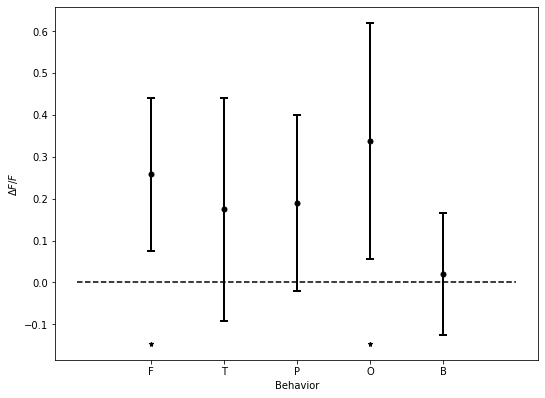

In [20]:
visualize_coefficient_stats(var_strs=test_behs, theta=test_betas, c_ints=test_c_ints, sig=test_sig, x_axis_rot=0)
plt.ylabel('$\Delta F / F$')
plt.xlabel('Behavior')
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(8, 6)


In [ ]:
data